In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, time
sys.path.insert(1, '../discrete_mixflows/')
from discrete_mixflows import *
from gibbs import *
from concrete import *

plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams["figure.figsize"]=15,7.5
plt.rcParams.update({'font.size': 24})

In [2]:
########################
########################
# target specification #
########################
########################
np.random.seed(2023)
K1=10
prbs=np.random.rand(K1)
prbs=prbs/np.sum(prbs)
def lp(x,axis=None):
    # compute the univariate log joint and conditional target pmfs
    #
    # inputs:
    #    x    : (1,d) array with state values
    #    axis : int, full conditional to calculate; returns joint if None
    # outputs:
    #   ext_lprb : if axis is None, (d,) array with log joint; else, (d,K1) array with d conditionals 
    
    ext_lprb=np.log(np.repeat(prbs[:,np.newaxis],x.shape[1],axis=1).T)
    if axis==None: return np.squeeze(ext_lprb[np.arange(0,x.shape[1]),x])
    return ext_lprb

## IDF
from https://github.com/jmtomczak/intro_dgm/blob/main/flows/idf_example.ipynb

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

In [151]:
# Chakraborty & Chakravarty, "A new discrete probability distribution with integer support on (−∞, ∞)",
#  Communications in Statistics - Theory and Methods, 45:2, 492-505, DOI: 10.1080/03610926.2013.830743

def log_min_exp(a, b, epsilon=1e-8):
    """
    Source: https://github.com/jornpeters/integer_discrete_flows
    Computes the log of exp(a) - exp(b) in a (more) numerically stable fashion.
    Using:
     log(exp(a) - exp(b))
     c + log(exp(a-c) - exp(b-c))
     a + log(1 - exp(b-a))
    And note that we assume b < a always.
    """
    y = a + torch.log(1 - torch.exp(b - a) + epsilon)

    return y

def log_integer_probability(x, mean, logscale):
    scale = torch.exp(logscale)

    logp = log_min_exp(
        F.logsigmoid((x + 0.5 - mean) / scale),
        F.logsigmoid((x - 0.5 - mean) / scale))

    return logp

In [152]:
# Source: https://github.com/jornpeters/integer_discrete_flows
class RoundStraightThrough(torch.autograd.Function):
    
    def __init__(self):
        super().__init__()

    @staticmethod
    def forward(ctx, x):
        rounded = torch.round(x, out=None)
        return rounded

    @staticmethod
    def backward(ctx, grad_output):
        grad_input = grad_output.clone()
        return grad_input

In [484]:
class IDF(nn.Module):
    def __init__(self, netts, num_flows, lprbs, D):
        super(IDF, self).__init__()
        
        if len(netts) == 1:
            self.t = torch.nn.ModuleList([netts[0]() for _ in range(num_flows)])
            self.idf_git = 1
        else:
            raise ValueError('You can provide either 1 or 4 translation nets.')
        
        self.num_flows = num_flows

        self.round = RoundStraightThrough.apply
        
        #self.mean = nn.Parameter(torch.zeros(1, D))
        #self.logscale = nn.Parameter(torch.ones(1, D))
        self.lprbs = lprbs
        self.ref = torch.distributions.categorical.Categorical(torch.ones(lprbs.shape[0])/lprbs.shape[0],
                                                              validate_args=False)

        self.D = 1

    def coupling(self, x, index, forward=True):
        
        xa=x
        xb=x
        if self.D>1: (xa, xb) = torch.chunk(x, 2, 0)
        if forward:
            yb = xb + self.round(self.t[index](xa))
        else:
            yb = xb - self.round(self.t[index](xa))
        if self.D>1: return torch.cat((xa, yb), 0)
        return yb

    def permute(self, x):
        return x.flip(1)

    def forward(self, x):
        z = x
        for i in range(self.num_flows):
            z = self.coupling(z, i, forward=True)
            z = self.permute(z)
        return z

    def backward(self, z):
        x = z
        for i in reversed(range(self.num_flows)):
            x = self.permute(x)
            x = self.coupling(x, i, forward=False)
        return x

    def log_prob(self, x):
        z = self.backward(x)
        return -self.log_prior(z)

    def sample(self, batchSize):
        # sample z:
        z = self.prior_sample(batchSize=batchSize, D=self.D)
        x = self.forward(z)
        return x

    def log_prior(self, x):
        #log_p = log_integer_probability(x, self.mean, self.logscale)
        #return log_p.sum(-1)
        flags=(x<=0)|(x>self.lprbs.shape[0])
        x[flags]=1
        out=self.ref.log_prob(x)
        out[flags]=np.log(1e-32)
        return out

    def prior_sample(self, batchSize, D=2):
        # Sample from logistic
        #y = torch.rand(batchSize, self.D)
        #x = torch.exp(self.logscale) * torch.log(y / (1. - y)) + self.mean
        # And then round it to an integer.
        #return torch.round(x)
        return self.ref.sample(batchSize)

In [946]:
class myIDF(nn.Module):
    """
    
    """
    def __init__(self, netts, num_flows, mask, ref, lprbs, dim):
        super(myIDF, self).__init__()
        
        self.ref = ref
        self.t = torch.nn.ModuleList([netts[0]() for _ in range(num_flows)])
        self.mask = nn.Parameter(mask, requires_grad=False)
        self.round = RoundStraightThrough.apply
        self.num_flows=num_flows
        self.lprbs=lprbs
        self.dim=dim
        
        
    def forward(self, z):
        x = z
        for i in range(self.num_flows):
            x_ = x*self.mask[i]
            t = self.round(self.t[i](x_))*(1 - self.mask[i])
            x = x_ + (1-self.mask[i]) * (x+t)
        return x

    def backward(self, x):
        z = x#[:,None]
        for i in reversed(range(self.num_flows)):
            z_ = self.mask[i]*x
            t = self.round(self.t[i](z_)) * (1-self.mask[i])
            z = (1 - self.mask[i]) * (z-t) + z_
            #z=z-self.round(self.t[i](z))
            print(i)
            print(z.grad_fn)
        return z
    
    def log_prob(self,x):
        z = self.backward(x)
        #return self.ref.log_prob(z)
        return self.ref_log_prob(z)
    
    def ref_log_prob(self, x):
        flags=(x<=0)|(x>self.lprbs.shape[0])
        x[flags]=1
        out=self.ref.log_prob(x)
        out[flags]=np.log(1e-32)
        return out
        
    def sample(self, batchSize): 
        z = self.ref.sample((batchSize, 1)).float()
        x = self.forward(z)
        return x

In [947]:
def createIDF(depth,lprbs,layers=32):
    dim=lprbs.ndim
    
    ref=torch.distributions.categorical.Categorical(
        torch.ones(lprbs.shape[0])/lprbs.shape[0],
        validate_args=False
    )
    
    masks=torch.zeros((2,dim))
    masks[0,:(dim//2)]=1
    masks[1,(dim-(dim//2)):]=1
    masks=masks.repeat(depth//2,1)
    
    inlayers=1 if dim==1 else dim//2
    nett = lambda: nn.Sequential(
        nn.Linear(inlayers, layers), 
        nn.LeakyReLU(),
        nn.Linear(layers, layers), 
        nn.LeakyReLU(),
        nn.Linear(layers, inlayers)
    )
    netts = [nett]

    # Init IDF
    #return IDF(netts, depth, lprbs, dim)
    return myIDF(netts=netts, num_flows=depth, mask=masks, ref=ref, lprbs=lprbs, dim=dim)

In [948]:
from torch.autograd import Variable
def trainIDF(depth,lprbs,layers=32,max_iters=1000,lr=1e-4,mc_ss=1000,seed=0,verbose=True):
    """
    Train an integer discrete flow (IDF) targeting lprbs using the Adam optimizer
    
    Input:
        temp      : float, temperature of Concrete relaxation
        depth     : int, number of couplings (transformations)
        lprbs     : (dim,) array, target log probabilities
        layers    : int, width of the linear layers
        max_iters : int, max number of Adam iters
        lr        : float, Adam learning rate
        mc_ss     : int, number of samples to draw from target for training
        seed      : int, for reproducinility
        verbose   : boolean, indicating whether to print loss every 100 iterations of Adam
    """
    torch.manual_seed(seed)
    
    # create flow
    flow=createIDF(depth,lprbs,layers)
    target = torch.distributions.categorical.Categorical(torch.tensor(np.exp(lprbs)))
    
    # train flow
    sample=target.sample((mc_ss,1)).float()
    optimizer = torch.optim.Adam([p for p in flow.parameters() if p.requires_grad==True], lr=lr)
    losses=np.zeros(max_iters)
    
    for t in range(max_iters):
        loss = -flow.log_prob(sample).mean()
        #loss = Variable(loss, requires_grad = True)
        losses[t]=loss
        
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        
        if verbose and t%(max_iters//10) == 0: print('iter %s:' % t, 'loss = %.3f' % loss)
    # end for
    return flow,losses

In [949]:
max_iters=101
flow,losses=trainIDF(depth=10,lprbs=np.log(prbs),layers=32,max_iters=max_iters,lr=1e-2,mc_ss=10,seed=2023,verbose=True)

9
8
7
6
5
4
3
2
1
0


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

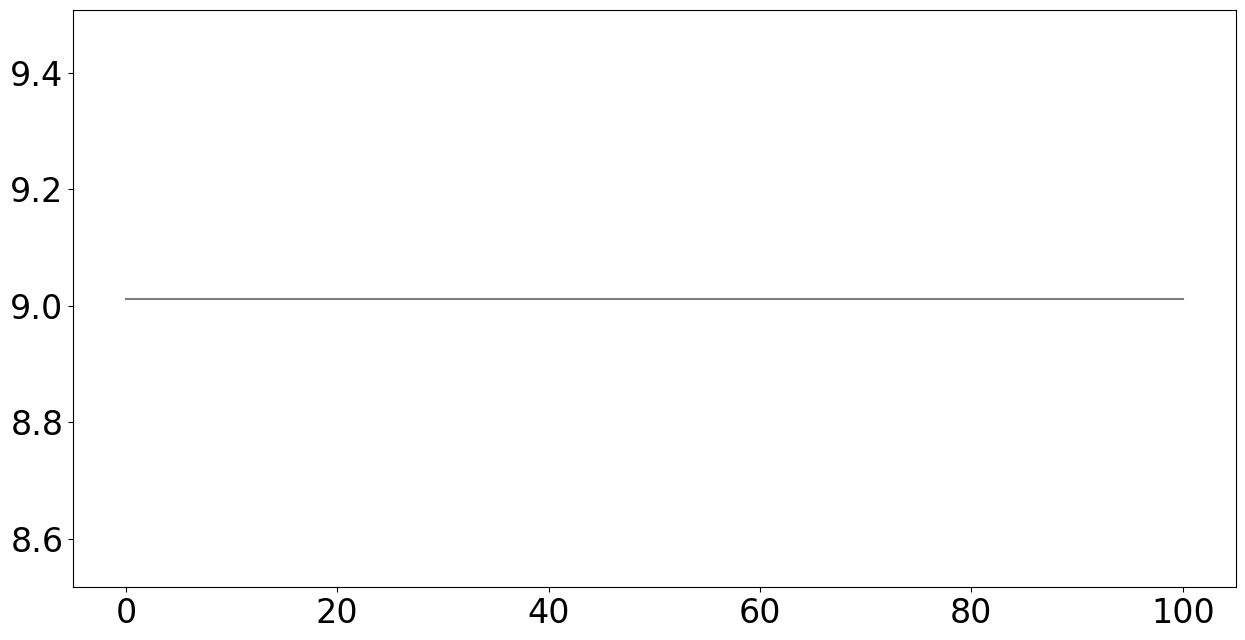

In [769]:
plt.plot(np.arange(max_iters),losses,'-k',alpha=0.5)

(array([0.1098889 , 0.10833334, 0.10755556, 0.11188891, 0.11200002,
        0.11444443, 0.10988894, 0.11377777, 0.10922227, 0.1141111 ]),
 array([-0.56738377,  0.33261615,  1.23261607,  2.13261604,  3.0326159 ,
         3.93261576,  4.83261585,  5.73261547,  6.63261557,  7.53261518,
         8.43261528]),
 <BarContainer object of 10 artists>)

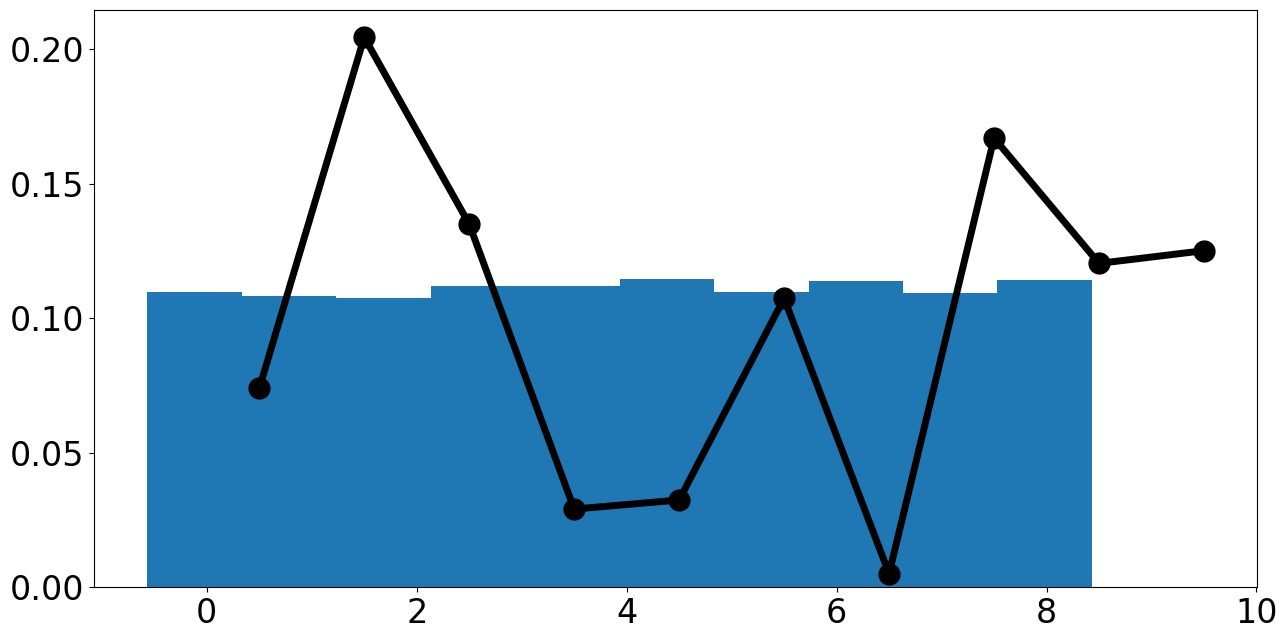

In [855]:
ttx=np.arange(0,K1)
plt.plot(ttx+0.5,prbs,c="black", label=r'$\pi(x)$',lw=5,ms=15,marker='o')
plt.hist(torch.squeeze(flow.sample(10000)).detach().numpy(),bins=10,density=True)